# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model; compute_MAP=true);

In [8]:
target.vsyms[1]

Ωm

In [9]:
samples_mchmc = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       monitor_energy=true, 
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.450434798529253, 0.06088870443741783] ✅


eps: 0.5 --> VarE: 0.6753670948697426
eps: 0.6917613343373408 --> VarE: 1.060109817101526
eps: 0.6533172048672904 --> VarE: 1.0003376811975426


[ Info: Found eps: 0.6533172048672904 ✅


samples: 100--> ESS: 0.10145530382808787


[ Info: Found L: 2.57578334583399 ✅


In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

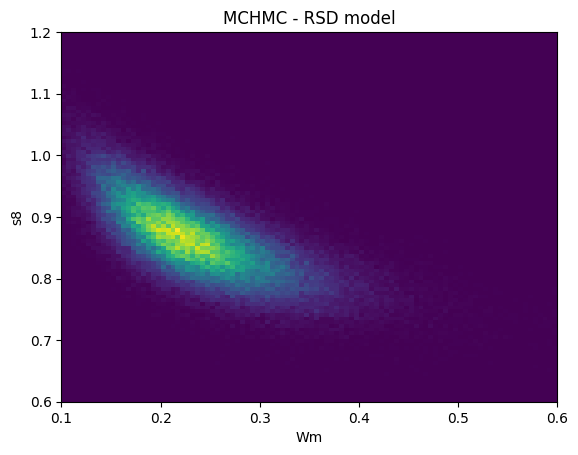

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [12]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=0.05), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅


eps: 0.5 --> VarE: 2.209658835134417
eps: 0.09046375409897209 --> VarE: 6.64270049315915
eps: 0.00026232575923205775 --> VarE: 6.991866798679044e-5
eps: 0.00041237887705420246 --> VarE: 0.00042431999984143793
eps: 0.0006339254139324219 --> VarE: 0.0012473171152621876
eps: 0.0009536297215277413 --> VarE: 0.002873580546067794
eps: 0.001404501772124429 --> VarE: 0.004969249519227011
eps: 0.002026703191081553 --> VarE: 0.0033885327502072705
eps: 0.002875902722074542 --> VarE: 0.0027465563103809
eps: 0.004013587848157976 --> VarE: 0.010613167989378232
eps: 0.005483438609390178 --> VarE: 0.01827445814356153
eps: 0.007344220653973022 --> VarE: 0.04867078339961565
eps: 0.00952869721047942 --> VarE: 0.12876620889567875
eps: 0.011681955993176531 --> VarE: 0.2901126265794904
eps: 0.013034715814715539 --> VarE: 0.39195170030908183
eps: 0.01375319888400847 --> VarE: 0.4550075758800084


[ Info: VarE condition met during eps tuning at step: 16
[ Info: Found eps: 0.01375319888400847 ✅


Initial Virial loss: 3830.132998251572
Initial sigma: [1.6589932078901006, 0.2702455490681111]
Virial loss: 60.37876276882627 --> Relative improvement: 0.024387665916238865
Sigma --> [1.6532189293825035, 0.2682606639439856]
Virial loss: 58.86936748815531 --> Relative improvement: 0.02499877790556948
Sigma --> [1.6497844441509948, 0.2667735914957312]
Virial loss: 57.38924454944389 --> Relative improvement: 0.02514249773465338
Sigma --> [1.646802931303942, 0.2654278049343582]
Virial loss: 55.944329268214986 --> Relative improvement: 0.025177457772318834
Sigma --> [1.643955590996391, 0.264148477909593]
Virial loss: 54.53601406180784 --> Relative improvement: 0.02517351132507517
Sigma --> [1.6411538984642366, 0.2629093627764316]
Virial loss: 53.16424707161651 --> Relative improvement: 0.025153414927549633
Sigma --> [1.6383660923742933, 0.26169865445898255]
Virial loss: 51.828360540137034 --> Relative improvement: 0.02512753598635431
Sigma --> [1.6355786189297759, 0.2605101664338617]
Virial

Sigma --> [1.4496095002940537, 0.20369477375524073]
Virial loss: 5.501049881385796 --> Relative improvement: 0.040850838087267416
Sigma --> [1.4470097482019508, 0.2030279602373822]
Virial loss: 5.278702179260052 --> Relative improvement: 0.04041913942247899
Sigma --> [1.4444235022906544, 0.20236744306425136]
Virial loss: 5.068656189012137 --> Relative improvement: 0.03979121820381959
Sigma --> [1.4418506560745021, 0.2017132205363795]
Virial loss: 4.87112182186251 --> Relative improvement: 0.038971743157060756
Sigma --> [1.4392911060601474, 0.20106528523527104]
Virial loss: 4.686082299868864 --> Relative improvement: 0.0379870446194045
Sigma --> [1.4367447599671528, 0.20042362219981547]
Virial loss: 4.5132060825205 --> Relative improvement: 0.036891417240623725
Sigma --> [1.4342115407203322, 0.19978820702070105]
Virial loss: 4.351763962448282 --> Relative improvement: 0.03577104991892088
Sigma --> [1.4316913873927746, 0.19915900403386186]
Virial loss: 4.200581861949822 --> Relative impr

[ Info: Virial loss condition met during burn-in at step: 97
[ Info: Found sigma: [1.388728572246419, 0.18881847705849053] ✅


eps: 0.01375319888400847 --> VarE: 0.0002745093282230704
eps: 0.014454372064846559 --> VarE: 0.0003091552714296765
eps: 0.01519076653646779 --> VarE: 0.0003491421986265442
eps: 0.01596403909875119 --> VarE: 0.00039541827951899814
eps: 0.01677589807750287 --> VarE: 0.00044927037422169984
eps: 0.017628095204371665 --> VarE: 0.0005125109236919824
eps: 0.018522411601209078 --> VarE: 0.0005878193019190054
eps: 0.019460633252887362 --> VarE: 0.0006791541384968005
eps: 0.02044451156520897 --> VarE: 0.0007919879625532945
eps: 0.021475708848091336 --> VarE: 0.0009329811702254257
eps: 0.022555738087350844 --> VarE: 0.001108632499661213
eps: 0.02368592196462394 --> VarE: 0.0013226793392861528
eps: 0.024867411778524806 --> VarE: 0.0015731225032656262
eps: 0.026101298391008675 --> VarE: 0.0018512690847370533
eps: 0.02738878959454134 --> VarE: 0.002144511057726315
eps: 0.02873136202791303 --> VarE: 0.0024416352800142854
eps: 0.030130792167540773 --> VarE: 0.0027384036331656275
eps: 0.031589008911001

[ Info: VarE condition met during eps tuning at step: 58
[ Info: Found eps: 0.09401074235623347 ✅


In [13]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

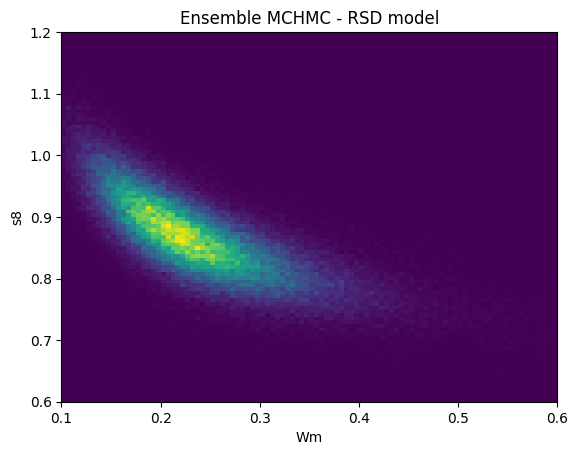

In [14]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [15]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 0.46667312403316247
eps: 

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.4504347985296616, 0.06088870443747282] ✅


2.31678325468799 --> VarE: 35.575500110259505
eps: 3.121667612187747e-14 --> VarE: 4.493865778650692e-29
eps: 1.9068584421171717e-13 --> VarE: 8.964324380184302e-29
eps: 1.0663994275239028e-12 --> VarE: 6.671636745016064e-28
eps: 5.48353222108313e-12 --> VarE: 1.579500897526749e-26
eps: 2.60326371377107e-11 --> VarE: 3.534522693368416e-25
eps: 1.1454725745546806e-10 --> VarE: 6.837947066115523e-24
eps: 4.688878650511751e-10 --> VarE: 1.1458840034823966e-22
eps: 1.7918497375806148e-9 --> VarE: 1.673575432681288e-21
eps: 6.4141389365251575e-9 --> VarE: 2.1445273067526975e-20
eps: 2.157566548983905e-8 --> VarE: 2.4265383288276957e-19
eps: 6.840635315308426e-8 --> VarE: 2.4393108535080625e-18
eps: 2.0501619476222603e-7 --> VarE: 2.19126985079018e-17
eps: 5.82413413698814e-7 --> VarE: 1.7689280442263205e-16
eps: 1.5723885882154431e-6 --> VarE: 1.290390877197454e-15
eps: 4.044382828435874e-6 --> VarE: 8.556180017280733e-15
eps: 9.93423518042213e-6 --> VarE: 5.1922098894305086e-14
eps: 2.3355

[ Info: Found eps: 0.9050612754587686 ✅
[ Info: Found L: 2.1274393070086646 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.92 seconds
Compute duration  = 1.92 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2390    0.0635     0.0006    0.0016   1660.4259    1.0006    ⋯
          σ8    0.8619    0.0578     0.0006    0.0013   1960.9048    1.0004    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1360    0.1950    0.2316    0.2753    0.3842
          σ8    0.7523    0.8229    0.8607    0.8987    0.9818


In [16]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.62 seconds
Compute duration  = 0.62 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2388    0.0635     0.0006    0.0014   1705.7557    0.9999    ⋯
          σ8    0.8625    0.0579     0.0006    0.0013   1873.0626    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1360    0.1931    0.2318    0.2765    0.3870
          σ8    0.7534    0.8230    0.8606    0.8997    0.9831


## Ensemble AbstractMCMC

In [17]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:163
[ Info: Found eps: 0.007776690125097311 ✅
[ Info: Virial loss condition met during burn-in at step: 17
[ Info: Found sigma: [1.6986608833848544, 0.301664966493382] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.01376805377716968 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 2.9 seconds
Compute duration  = 2.9 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2633    0.1706     0.0005    0.0091   226.9953    1.0011     ⋯
          σ8    0.7874    0.2910     0.0009    0.0155   227.4782    1.0000     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0214    0.1208    0.2273    0.4383    0.5558
          σ8    0.0889    0.6062    0.8141    0.9921    1.2733


In [18]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 2.77 seconds
Compute duration  = 2.77 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2424    0.0622     0.0002    0.0033   227.0401    1.0212     ⋯
          σ8    0.8603    0.0612     0.0002    0.0032   229.9280    1.0193     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1304    0.2055    0.2343    0.2751    0.3799
          σ8    0.7595    0.8201    0.8521    0.8941    0.9780


## Parallelization

In [19]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 0.7555170009334423
eps: 0.5 --> VarE: 1.3757134143456438
eps: 0.5 --> VarE: 0.7349312261174668
eps: 0.5 --> VarE: 2.188517293452103
eps: 1.735569876432059 --> VarE: 16.27183553686854
eps: 1.7716682083659774 --> VarE: 17.914275957929746
eps: 

[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852953816, 0.06088870443747054] ✅
[ Info: Found sigma: [0.45043479852953816, 0.06088870443747054] ✅
[ Info: Found sigma: [0.45043479852953816, 0.06088870443747054] ✅
[ Info: Found sigma: [0.45043479852953816, 0.06088870443747054] ✅


0.9334567996416088 --> VarE: 2.954229489774732
eps: 0.41409309055837284 --> VarE: 1.6270514504602227
eps: 2.2057254833275855e-6 --> VarE: 8.579000215417691e-14
eps: 4.7203817873365297e-7 --> VarE: 2.9328096630406526e-15
eps: 0.37660749420874096 --> VarE: 0.9299245231040707
eps: 0.5904296186494937 --> VarE: 2.5239243136966176
eps: 1.3473587778707089e-5 --> VarE: 8.630513192728364e-12
eps: 2.883426738342128e-6 --> VarE: 1.0944388400287767e-13
eps: 0.3675223436549081 --> VarE: 1.554616937329452
eps: 0.9917269796671905 --> VarE: 3.8055965659312014
eps: 7.5350251368668e-5 --> VarE: 1.165280626621905e-8
eps: 1.612539533695457e-5 --> VarE: 3.421803226527089e-12
eps: 0.5392228145052301 --> VarE: 2.210339301711377
eps: 0.20963260127627126 --> VarE: 0.5215298375713595
eps: 0.0003874585044219196 --> VarE: 5.96436436129975e-6
eps: 8.291839120071567e-5 --> VarE: 9.760758726525349e-11
eps: 0.4539184768822776 --> VarE: 1.9813472596331594
samples: 100--> ESS: 0.0943444183748312
samples: 203--> ESS: 0.

[ Info: Found eps: 0.4539184768822776 ✅
[ Info: Found L: 1.899293301480236 ✅
[ Info: Found eps: 0.7033294878537081 ✅
[ Info: Found L: 3.491037305903116 ✅


eps: 0.00809344423887798 --> VarE: 0.0007682267808514564
eps: 0.0017321087425216694 --> VarE: 1.097276328829455e-5
eps: 0.033111782967399576 --> VarE: 0.007543428709153946
eps: 0.007090160938112603 --> VarE: 0.0002048676641007537
eps: 0.12589809130329438 --> VarE: 0.08473319864669385
eps: 0.02709125019629904 --> VarE: 0.0032128827099631497
eps: 0.4269644740948059 --> VarE: 0.5699782610024481
eps: 0.09677788268783487 --> VarE: 0.031137962299980865
eps: 1.0164310903603855 --> VarE: 3.014609780669306
eps: 0.3194477341834104 --> VarE: 0.46372195689572376
eps: 0.5660451917609632 --> VarE: 0.76167072019268
eps: 0.7750666299727796 --> VarE: 1.1152169002443169
eps: 1.1168677976056718 --> VarE: 4.083209131543652
eps: 1.2595732604301568 --> VarE: 5.564832268998878
eps: 0.3764378301939392 --> VarE: 0.5358400941976881
eps: 0.1958839965128497 --> VarE: 0.18469231573661962
eps: 0.7788614700586571 --> VarE: 1.367144792044684
eps: 0.4824984688248586 --> VarE: 0.6603963202158726
eps: 1.0502387860122397

[ Info: Found eps: 0.9509955744517311 ✅
[ Info: Found L: 1.8619306464568766 ✅


eps: 0.9820975442483023 --> VarE: 2.4946781681664483
eps: 0.818692624530768 --> VarE: 1.2000651112887657
eps: 1.0831579941214213 --> VarE: 3.791646035183065
eps: 0.5966012484229983 --> VarE: 0.7189931410323159
eps: 0.895035012854284 --> VarE: 1.8719630234663296
eps: 0.9302253180350751 --> VarE: 1.9306296671834293
samples: 100--> ESS: 0.20521564849138368


[ Info: Found eps: 0.9302253180350751 ✅
[ Info: Found L: 1.813166441981411 ✅
chain 1:   5%|██▏                                       |  ETA: 0:00:02
chain 3:   6%|██▎                                       |  ETA: 0:00:02
chain 2:   6%|██▎                                       |  ETA: 0:00:02
chain 4:   6%|██▌                                       |  ETA: 0:00:02


chain 1:  11%|████▋                                     |  ETA: 0:00:02

chain 3:  12%|█████                                     |  ETA: 0:00:02
chain 2:  12%|█████                                     |  ETA: 0:00:02
chain 4:  13%|█████▌                                    |  ETA: 0:00:01

chain 1:  16%|██████▉                                   |  ETA: 0:00:02
chain 3:  18%|███████▊                                  |  ETA: 0:00:01
chain 2:  18%|███████▊                                  |  ETA: 0:00:01
chain 4:  20%|████████▎                                 |  ETA: 0:00:01

chain 1:  22%|█████████▎                              

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [20]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 1:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  10%|████▍                                     |  ETA: 0:00:02
chain 3:  10%|████▍                                     |  ETA: 0:00:02


chain 2:  10%|████▍                                     |  ETA: 0:00:02


chain 1:  16%|██████▉                                   |  ETA: 0:00:01
chain 4:  17%|███████▏                                  |  ETA: 0:00:01
chain 3:  17%|███████▏                                  |  ETA: 0:00:01

chain 2:  16%|██████▊                                   |  ETA: 0:00:02

chain 3:  23%|█████████▋                                |  ETA: 0:00:01

chain 4:  24%|█████████▉                                |  ETA: 0:00:01chain 1:  23%|█████████▋                                |  ETA: 0:00:01
chain 2:  22%|█████████                                 |  ETA: 0:00:01

chain 3:  30%|████████████▍                             |  ETA: 0:00:01
chain 4:  30%|████████

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [21]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 8.62 seconds
Compute duration  = 8.62 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2336    0.0629     0.0006    0.0016   1628.8842    1.0003    ⋯
          σ8    0.8678    0.0606     0.0006    0.0013   2523.3907    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

In [22]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.22113   0.899928  15.96    17.0  1.0  …  4.0  0.0  0.0672787  0.0672787
 0.271346  0.791448  15.3697  13.0  1.0     3.0  0.0  0.0672787  0.0672787
 0.209816  0.877654  16.2896  15.0  1.0     3.0  0.0  0.0672787  0.0672787
 0.242236  0.842272  16.233   15.0  1.0     3.0  0.0  0.0672787  0.0672787
 0.172794  0.897499  15.7988  23.0  1.0     4.0  0.0  0.0672787  0.0672787
 0.161705  0.87688   14.8523  15.0  1.0  …  4.0  0.0  0.0672787  0.0672787
 0.143067  0.902205  14.2767   5.0  1.0     2.0  0.0  0.0672787  0.0672787
 0.143067  0.902205  14.2767   1.0  1.0     1.0  0.0  0.0672787  0.0672787
 0.152664  0.940675  15.3771   7.0  1.0 

In [23]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

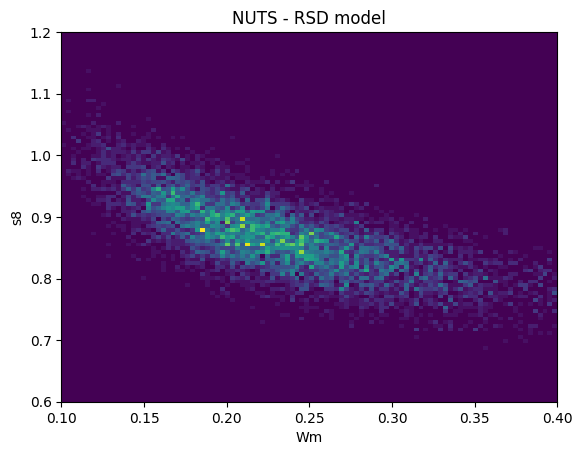

In [24]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");